In [1]:
#ensure cuda is working
import torch
assert torch.cuda.is_available()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA RTX A4500


In [2]:
import mira

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import scvelo as scv

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import matplotlib
import matplotlib as mpl
from copy import copy
reds = copy(mpl.cm.Reds)
reds.set_under("lightgray")

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k * h)[:3]) * 255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

plotly_reds = matplotlib_to_plotly(reds, 255)
plotly_reds[0] = [0.0, 'rgb(211, 211, 211)']

import plotly.express as px
from dash import Dash, dcc, html, Input, Output

import os
import sys
from pathlib import Path
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

project_directory = '/Cranio_Lab/Louk_Seton/mesenchyme_project_2023'
os.chdir(os.path.expanduser("~")+project_directory)

In [3]:
adata = sc.read('anndata_objects/dataset_cleaned.h5ad')


In [4]:
adata

AnnData object with n_obs × n_vars = 58973 × 22912
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'sample', 'barcode', 'batch', 'doublet_score', 'predicted_doublets', 'predicted_doublets_based_on_10x_chromium_spec', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'pct_counts_unspliced', 'pred_doubl_cat', 'stage'
    var: 'gene_name', 'ensembl_id', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [5]:
adata.layers['original_counts'] = adata.X.copy()


In [6]:
sc.pp.filter_genes(adata, min_cells=15)

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
sc.pp.scale(adata, max_value=10)
cell_cycle_genes = ['Mcm5','Pcna','Tyms','Fen1','Mcm2','Mcm4','Rrm1','Ung','Gins2','Mcm6',
                    'Cdca7','Dtl','Prim1','Uhrf1','Cenpu','Hells','Rfc2','Rpa2','Nasp',
                    'Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Pold3','Msh2','Atad2',
                    'Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2',
                    'Usp1','Clspn','Pola1','Chaf1b','Brip1','E2f8','Hmgb2','Cdk1','Nusap1',
                    'Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Mki67',
                    'Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb',
                    'Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3',
                    'Jpt1','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5',
                    'Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr',
                    'Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa',
                   ]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = s_genes + g2m_genes


cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
len(cell_cycle_genes)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [9]:
adata.X = adata.layers['original_counts'].copy()
del adata.uns['log1p']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, min_disp = 0.5)

In [13]:
adata.obs['source'] = 'lamanno'
adata.obs.loc[adata[adata.obs['batch'] == 'adata10'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata11'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata12'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata13'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata14'].obs.index,'source'] = 'kaucka' #C
adata.obs['source'] = adata.obs['source'].astype('category')

... storing 'phase' as categorical


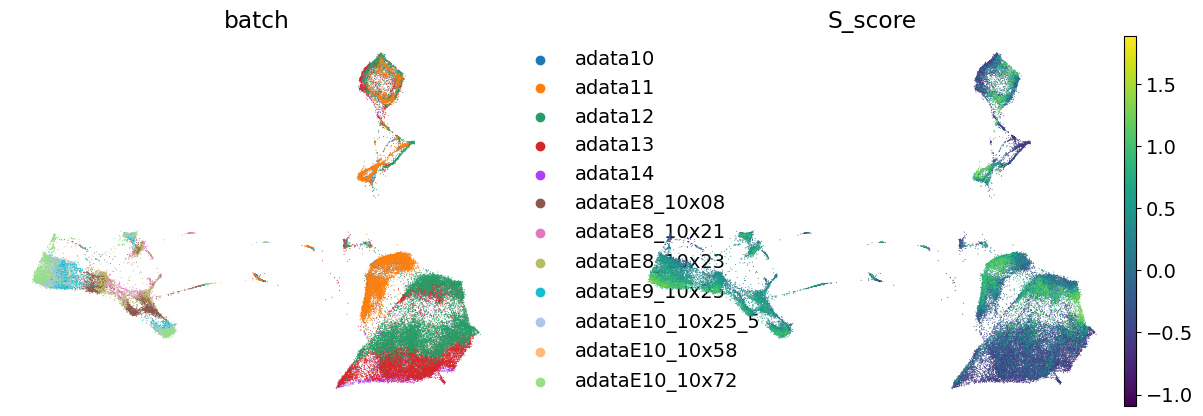

In [14]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=16)
sc.tl.umap(adata, min_dist = 0.2, negative_sample_rate=0.2)
sc.pl.umap(adata, color = ['batch','S_score'], frameon=False)

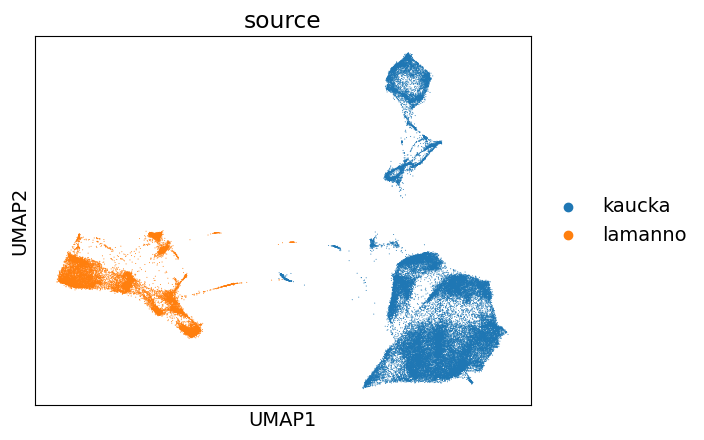

In [16]:
sc._settings.ScanpyConfig.figdir=Path('./figures/new_figures_after_review') #set figdir

sc.pl.umap(adata,color = 'source', save = 'all_cells_before_integration.svg')

In [12]:
##mira stuff
model = mira.topics.make_model(
    adata.n_obs, adata.n_vars, # helps MIRA choose reasonable values for some hyperparameters which are not tuned.
    feature_type = 'expression',
    highly_variable_key='highly_variable',
    counts_layer='original_counts',
    categorical_covariates='batch',
    continuous_covariates= ['S_score','G2M_score'],
)

In [13]:
model.get_learning_rate_bounds(adata)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Gathering dataset statistics:   0%|          | 0/58973 [00:00<?, ?it/s]

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (4.533008806160843e-06, 0.22248668375233174)


(4.533008806160843e-06, 0.22248668375233174)

<Axes: xlabel='Learning Rate', ylabel='Loss'>

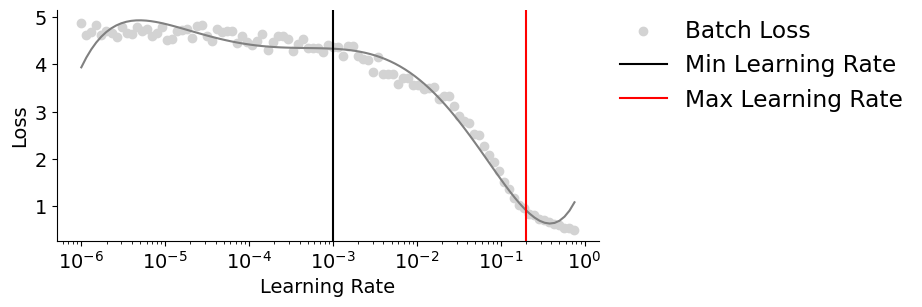

In [14]:
model.set_learning_rates(1e-3, 0.2) # for larger datasets, the default of 1e-3, 0.1 usually works well.
model.plot_learning_rate_bounds(figsize=(7,3))

In [15]:
topic_contributions = mira.topics.gradient_tune(model, adata)

Gathering dataset statistics:   0%|          | 0/58973 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting latent vars:   0%|          | 0/231 [00:00<?, ?it/s]

<Axes: xlabel='Topic Number', ylabel='Max contribution'>

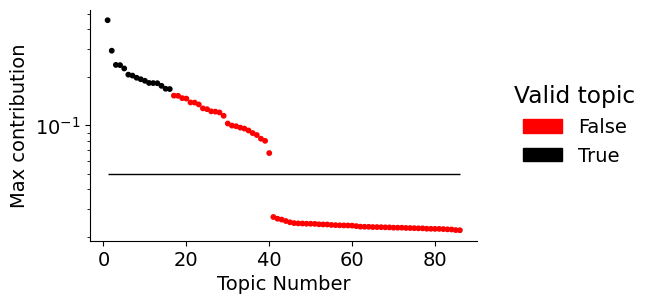

In [16]:
NUM_TOPICS = 16

mira.pl.plot_topic_contributions(topic_contributions, NUM_TOPICS)

In [17]:
NUM_TOPICS = 10
epoch = 50
model = model.set_params(num_topics = NUM_TOPICS,
                                num_epochs = epoch
                        ).fit(adata)


INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Gathering dataset statistics:   0%|          | 0/58973 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


In [18]:
model.predict(adata)


Predicting latent vars:   0%|          | 0/231 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [19]:
sc.pp.neighbors(adata, use_rep = 'X_umap_features', metric = 'manhattan',n_neighbors=30,)
sc.tl.leiden(adata, resolution = 1.2)



In [20]:
#sc.tl.umap(adata)
sc.tl.umap(adata, min_dist=0.5, negative_sample_rate=0.1)

In [21]:
sc.tl.leiden(adata, resolution = 1.4)


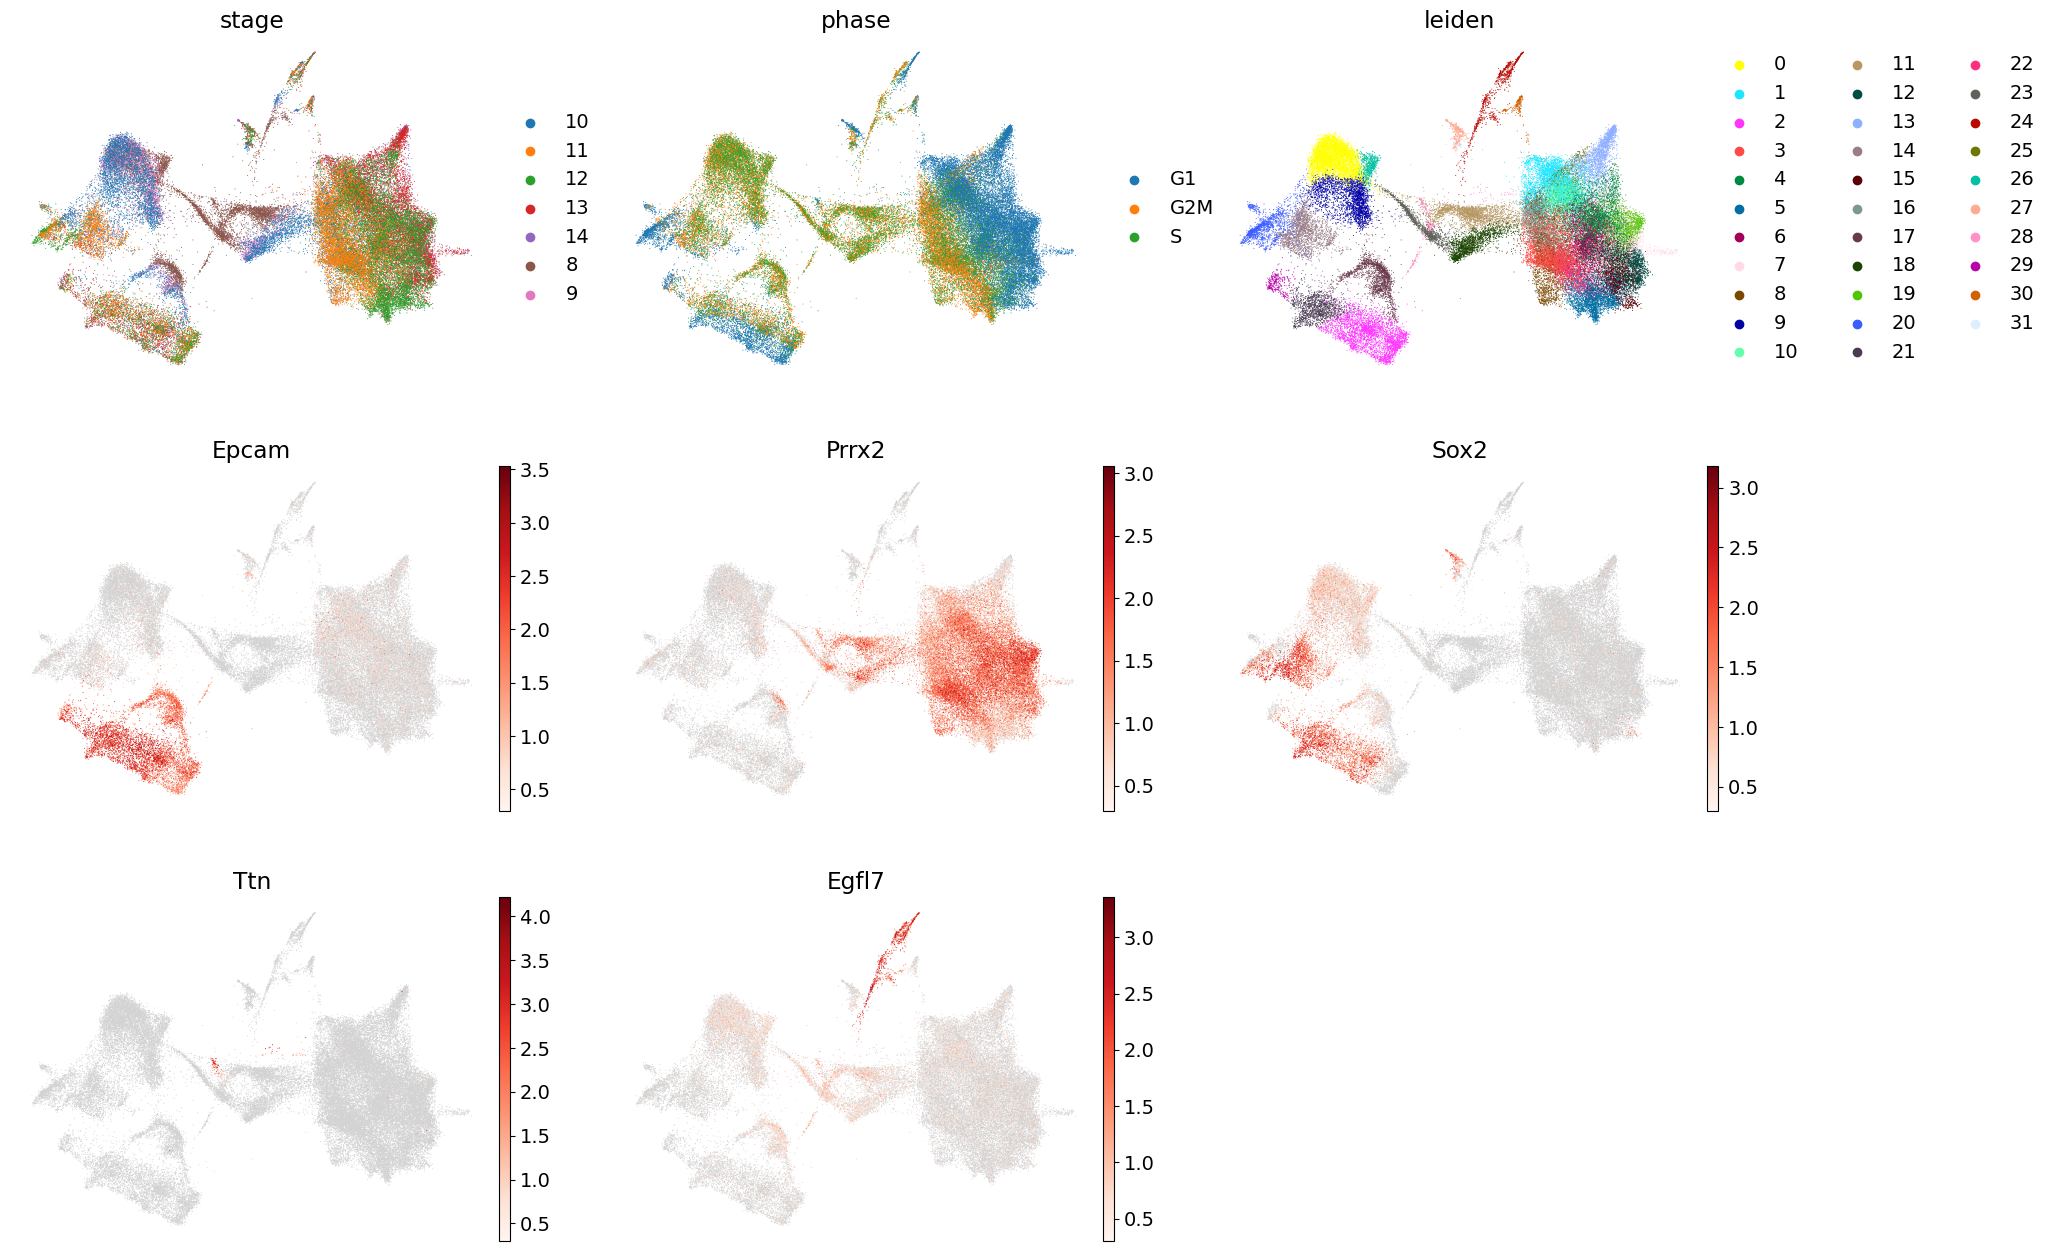

In [22]:
sc.pl.umap(adata, frameon=False, color = ['stage','phase','leiden','Epcam','Prrx2','Sox2','Ttn','Egfl7'],
           #groups=['21'],
           ncols=3,cmap=reds, vmin=0.3,)

In [30]:
adata.obs['annotation_all'] = 'test'
adata.obs.loc[adata[adata.obs['leiden'] == '0'].obs.index,'annotation_all'] = 'Brain' #C
adata.obs.loc[adata[adata.obs['leiden'] == '1'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '2'].obs.index,'annotation_all'] = 'Ectoderm' #C
adata.obs.loc[adata[adata.obs['leiden'] == '3'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '4'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '5'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '6'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '7'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '8'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '9'].obs.index,'annotation_all'] = 'Brain' #C
adata.obs.loc[adata[adata.obs['leiden'] == '10'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '11'].obs.index,'annotation_all'] = 'Mesoderm' #C
adata.obs.loc[adata[adata.obs['leiden'] == '12'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '13'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '14'].obs.index,'annotation_all'] = 'Brain' #C
adata.obs.loc[adata[adata.obs['leiden'] == '15'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '16'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '17'].obs.index,'annotation_all'] = 'Ectoderm' #C
adata.obs.loc[adata[adata.obs['leiden'] == '18'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '19'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '20'].obs.index,'annotation_all'] = 'Brain' #C
adata.obs.loc[adata[adata.obs['leiden'] == '21'].obs.index,'annotation_all'] = 'Ectoderm' #C
adata.obs.loc[adata[adata.obs['leiden'] == '22'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '23'].obs.index,'annotation_all'] = 'Neural Crest' #C
adata.obs.loc[adata[adata.obs['leiden'] == '24'].obs.index,'annotation_all'] = 'Endothelium' #C
adata.obs.loc[adata[adata.obs['leiden'] == '25'].obs.index,'annotation_all'] = 'Mesenchyme' #C
adata.obs.loc[adata[adata.obs['leiden'] == '26'].obs.index,'annotation_all'] = 'Brain' #C
adata.obs.loc[adata[adata.obs['leiden'] == '27'].obs.index,'annotation_all'] = 'Glia' #C
adata.obs.loc[adata[adata.obs['leiden'] == '28'].obs.index,'annotation_all'] = 'Muscle' #C
adata.obs.loc[adata[adata.obs['leiden'] == '29'].obs.index,'annotation_all'] = 'Ectoderm' #C
adata.obs.loc[adata[adata.obs['leiden'] == '30'].obs.index,'annotation_all'] = 'Immune Cells' #C
adata.obs.loc[adata[adata.obs['leiden'] == '31'].obs.index,'annotation_all'] = 'Glia' #C

adata.obs['annotation_all'] = adata.obs['annotation_all'].astype('category')
adata.obs['annotation_all'].cat.categories

Index(['Brain', 'Ectoderm', 'Endothelium', 'Glia', 'Immune Cells',
       'Mesenchyme', 'Mesoderm', 'Muscle', 'Neural Crest'],
      dtype='object')

In [18]:
adata.obs['source'] = 'lamanno'
adata.obs.loc[adata[adata.obs['batch'] == 'adata10'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata11'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata12'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata13'].obs.index,'source'] = 'kaucka' #C
adata.obs.loc[adata[adata.obs['batch'] == 'adata14'].obs.index,'source'] = 'kaucka' #C
adata.obs['source'] = adata.obs['source'].astype('category')

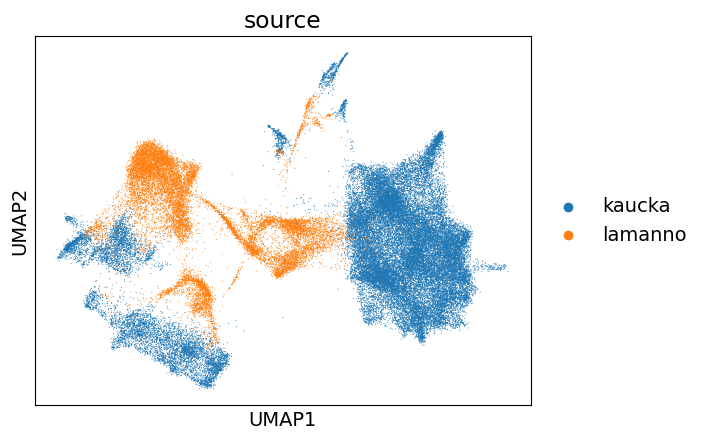

In [19]:
sc._settings.ScanpyConfig.figdir=Path('./figures/new_figures_after_review') #set figdir

sc.pl.umap(adata,color = 'source', save = 'all_cells_after_integration.svg')

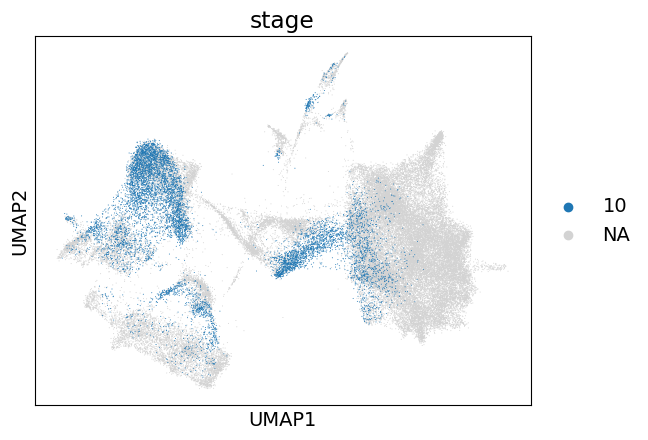

In [20]:
sc.pl.umap(adata,color = 'stage',groups = ['10'], save = 'all_cells_after_integration_stage.svg')